In [13]:
## Goals of this experiment:
## - SGHMCHD is more robust with respect to different initial (smaller) stepsizes than SGHMC [x]
## - SGHMCHD maintains reasonable uncertainty bounds of SGHMC [x]

# XXX: This can be considered done up to minor details, in particular
# plot titles 
# (How is it best to reflect stepsize and number of datapoints in 
# our plots?)
%matplotlib inline
import numpy as np
import sys
from os.path import dirname, expanduser, join as path_join, isdir
from glob import glob
import json
import pandas as pd
import seaborn as sns

from collections import defaultdict

sys.path.insert(0, path_join("..", "..", ".."))
from pysgmcmc_experiments import plot_utils
from pysgmcmc_experiments.utils import format_tex

RESULT_DIR = path_join("..", "..", "..", "cluster_results", "sinc")


def load_results(directory):
    directories = [
        directory for directory in glob("{}/*".format(directory))
        if isdir(directory)
    ]
    
    def load_json(filename):
        with open(filename) as f:
            return json.load(f)
    
    configurations = tuple(
        load_json(path_join(directory, "config.json"))
        for directory in directories
        if "_sources" not in directory
    )
    
    results = tuple(
        load_json(path_join(directory, "run.json"))
        for directory in directories
        if "_sources" not in directory
    )
    from collections import defaultdict
    runs_low_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    runs_high_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    
    assert len(configurations) == len(results)
    print(len(configurations))
    for configuration, result in zip(configurations, results):
        if result["status"] == "COMPLETED":
            num_data_points = len(result["result"]["y_train"])
            if num_data_points == 20:
                runs_low_data[configuration["data_seed"]][configuration["stepsize"]][configuration["sampler"]] = result
            else:
                runs_high_data[configuration["data_seed"]][configuration["stepsize"]][configuration["sampler"]] = result

    return runs_low_data, runs_high_data

runs_low_data, runs_high_data = load_results(RESULT_DIR)

COLORS = {"SGHMC": ("red", "indianred"), 
          "SGHMCHD": ("green", "forestgreen")}

PLOT_DIRECTORY = path_join(
    expanduser("~"),
    "thesis_repos", "masterthesis_report", "sghmchd",
    "experiments",  "results", "plots", "sinc",
)

def plot_datapoints(x_train, y_train):
    sns.lmplot(
        "x", "y",
        data=pd.DataFrame.from_records({
            "x": np.squeeze(x_train).tolist(),
            "y": np.squeeze(y_train).tolist()
        }), fit_reg=False, 
        scatter=True, scatter_kws={"s": 50}
    )



def plot_results(results, data_seed, suffix, confidence_intervals=[68, 95]):
    stepsizes = sorted(results)
    for stepsize in stepsizes:
        fig = plt.figure()
        sampler_results = results[stepsize]
        sampler_result = tuple(sampler_results.values())[0]
        
        x_train = np.asarray(sampler_result["result"]["x_train"])
        y_train = np.asarray(sampler_result["result"]["y_train"])
        plot_datapoints(x_train=x_train, y_train=y_train)

        x_train = np.asarray(sampler_result["result"]["x_train"])
        y_train = np.asarray(sampler_result["result"]["y_train"])
        
        x_test = np.squeeze(sampler_result["result"]["x_test"])
        y_test = np.asarray(sampler_result["result"]["y_test"])
        
        # xs, ys, ids, traces = [], [], [], []
        xs = x_test.tolist()
        ys = y_test.tolist()
        ids = [0] * len(x_test)
        traces = ["sinc(x)"] * len(x_test)
        for sampler, sampler_result in sampler_results.items():
            # color_prediction, color_uncertainty = COLORS[sampler]
            prediction_mean = np.asarray(sampler_result["result"]["prediction_mean"])
            prediction_std = np.asarray(sampler_result["result"]["prediction_std"])
            
            
            for x, y, mean, std in zip(x_test, y_test, prediction_mean, prediction_std):
                xs.append(x)
                ys.append(mean)
                ids.append(0)
                traces.append(sampler)
                
                xs.append(x)
                ys.append(mean + std)
                ids.append(1)
                traces.append(sampler)
                
                xs.append(x)
                ys.append(mean - std)
                ids.append(2)
                traces.append(sampler)
        
        data = pd.DataFrame.from_records({
            "x": xs, "y": ys, "id": ids, "trace": traces
        })
        
        if confidence_intervals:
            sns.tsplot(
                time="x", value="y", 
                unit="id", condition="trace",
                data=data, 
                color=((0, 0, 0), *(sns.color_palette("Set2", 10)[1:])),
                ci=confidence_intervals, 
            )
        else:
            sns.tsplot(
                time="x", value="y", 
                unit="id", condition="trace",
                data=data,
                color=((0, 0, 0), *(sns.color_palette("Set2", 10)[1:])),
            )
        
        plt.title("$\epsilon_0 = {}$".format(format_tex(stepsize)), fontsize=plot_utils.FONTSIZES["title"])
        plt.xlabel("x", fontsize=plot_utils.FONTSIZES["xlabel"])
        plt.ylabel("y", fontsize=plot_utils.FONTSIZES["ylabel"], rotation=0)
        
        plt.legend()
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)

        plt.savefig(path_join(PLOT_DIRECTORY, "{}_{}.pdf".format(str(stepsize).replace(".", "_"), suffix)), format="pdf")
    plt.show()

24


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


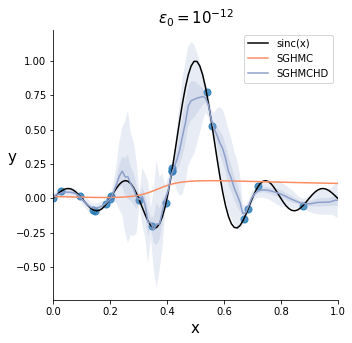

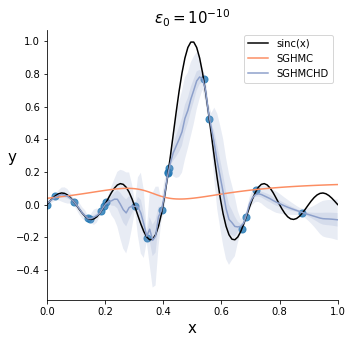

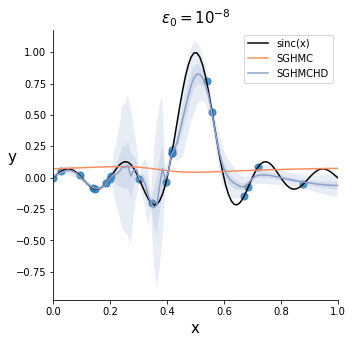

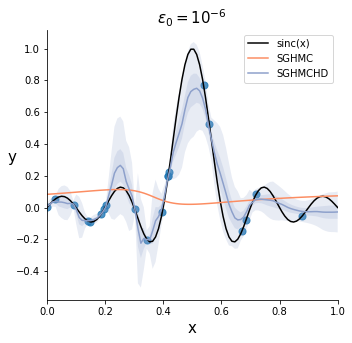

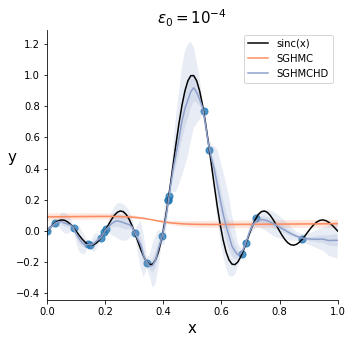

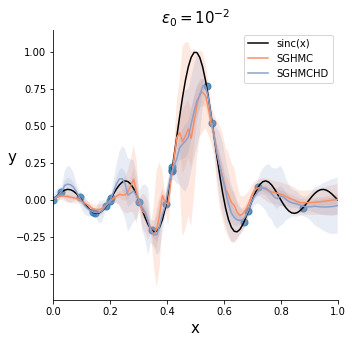

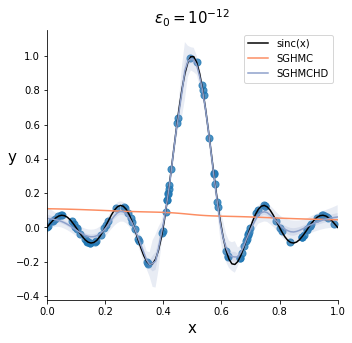

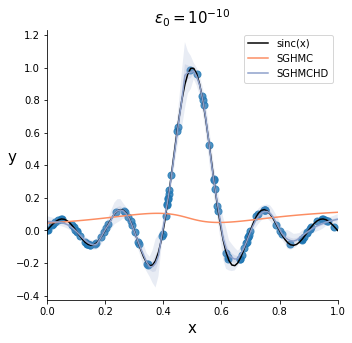

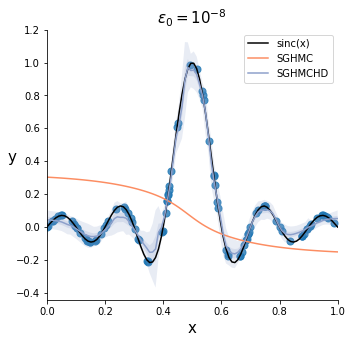

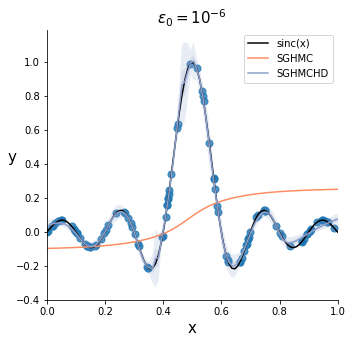

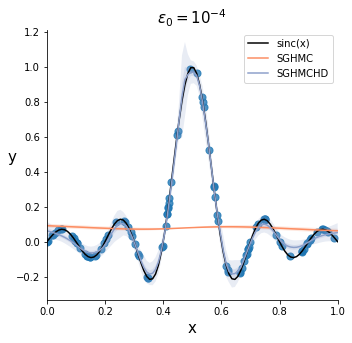

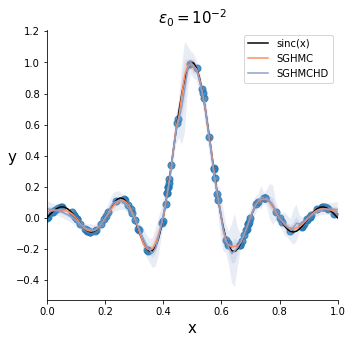

In [14]:
import matplotlib.pyplot as plt

data_seed = 1
seed_results = runs_high_data[data_seed]
plot_results(
    runs_low_data[data_seed], data_seed, suffix="20_observations", # confidence_intervals=None
)
plot_results(
    runs_high_data[data_seed], data_seed, suffix="100_observations", # confidence_intervals=None
)
